In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Oral_Dataset"
classes = ['gingivitis', 'hypodontia', 'toothDiscoloration', 'ulcers']

for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_folder))
    print(f'{class_name}: {num_images} images')

gingivitis: 644 images
hypodontia: 1267 images
toothDiscoloration: 1834 images
ulcers: 2555 images


In [ ]:
from PIL import Image
image_path = '/content/drive/MyDrive/Oral_Dataset/hypodontia/(1).JPG'
img = Image.open(image_path)
print(img.size)  # (width, height)


(292, 143)


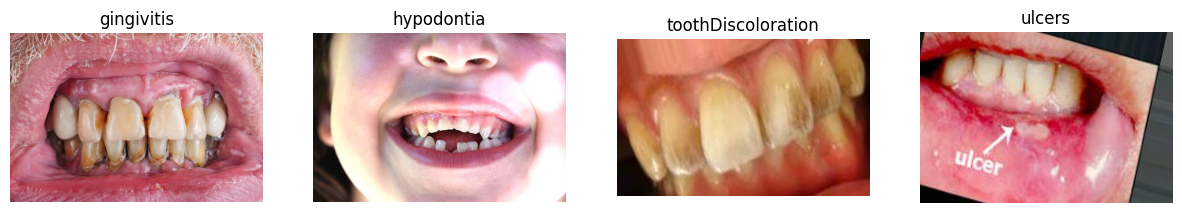

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

def show_sample_images(dataset_path, classes):
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(dataset_path, class_name)
        img_file = random.choice(os.listdir(class_folder))
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    plt.show()

show_sample_images(dataset_path, classes)

In [ ]:
# Verify image shapes
from PIL import Image

for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    img_file = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_file)
    img = Image.open(img_path)
    print(f"Class: {class_name}, Image: {img_file}, Shape: {img.size}, Mode: {img.mode}")

Class: gingivitis, Image: (1349).jpg, Shape: (612, 408), Mode: RGB
Class: hypodontia, Image: (119).jpg, Shape: (612, 408), Mode: RGB
Class: toothDiscoloration, Image: Tooth_Discoloration_0_1916.jpeg, Shape: (295, 171), Mode: RGB
Class: ulcers, Image: Mouth_Ulcer_0_9796.jpeg, Shape: (239, 211), Mode: RGB


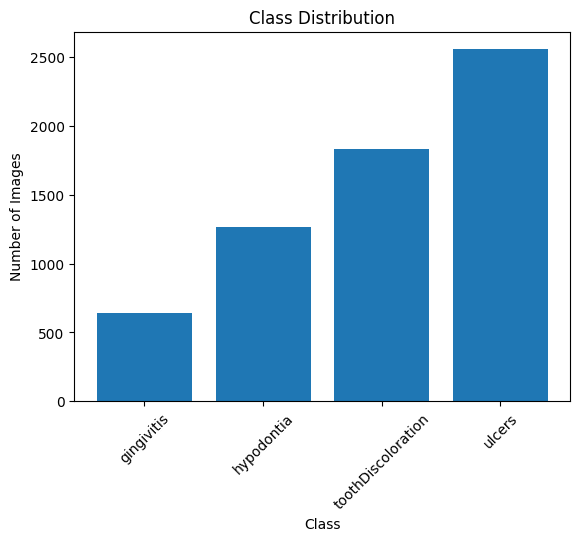

In [ ]:
import matplotlib.pyplot as plt

class_counts = []
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    class_counts.append(len(os.listdir(class_folder)))

plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


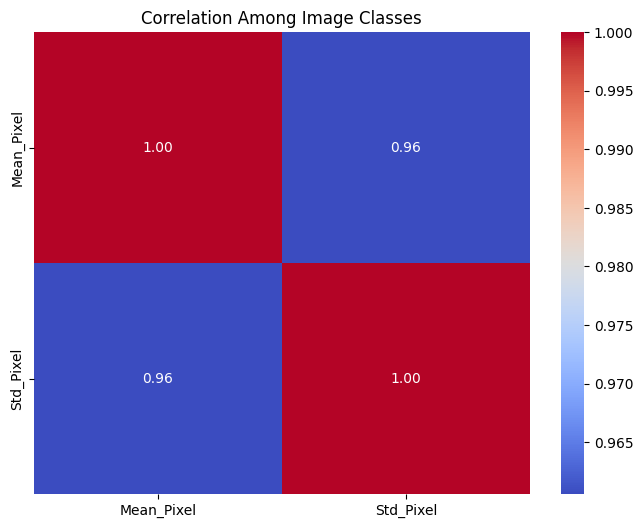

                    Mean_Pixel  Std_Pixel
Class                                    
gingivitis          130.816527  50.319291
hypodontia          136.333071  63.107509
toothDiscoloration  129.490140  46.245785
ulcers              131.307384  46.645034


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset path and classes
dataset_path = "/content/drive/MyDrive/Oral_Dataset"
classes = ['gingivitis', 'hypodontia', 'toothDiscoloration', 'ulcers']

# Function to extract features from images
def extract_image_features(dataset_path, classes):
    data = []
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_array = np.array(img)

            # Extract features
            mean_pixel = np.mean(img_array)  # Mean pixel intensity
            std_pixel = np.std(img_array)   # Standard deviation
            data.append([class_name, mean_pixel, std_pixel])
    return pd.DataFrame(data, columns=['Class', 'Mean_Pixel', 'Std_Pixel'])

# Extract features from the dataset
image_features = extract_image_features(dataset_path, classes)

# Calculate mean values per class for each feature
class_features = image_features.groupby('Class').mean()

# Compute correlation matrix
correlation_matrix = class_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Among Image Classes')
plt.show()

# Display the processed features (optional)
print(class_features)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Prepare training and validation generators
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(224, 224),  # Image size suitable for the model
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Classes: {train_generator.class_indices}")



Found 10319 images belonging to 7 classes.
Found 2576 images belonging to 7 classes.
Classes: {'.ipynb_checkpoints': 0, 'gingivitis': 1, 'hypodontia': 2, 'toothDiscoloration': 3, 'train': 4, 'ulcers': 5, 'validation': 6}


In [ ]:
train_path = '/content/drive/MyDrive/Oral_Dataset/train'
val_path = '/content/drive/MyDrive/Oral_Dataset/validation'

# Ensure paths contain only the 4 classes
print("Training classes:", os.listdir(train_path))
print("Validation classes:", os.listdir(val_path))


Training classes: ['gingivitis', 'hypodontia', 'toothDiscoloration', 'ulcers']
Validation classes: ['gingivitis', 'hypodontia', 'toothDiscoloration', 'ulcers']


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load InceptionV3 with pretrained weights (exclude the top fully connected layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = Sequential([
    base_model,  # The pretrained InceptionV3 base model
    GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(128, activation='relu'),  # Dense layer
    Dropout(0.5),  # Dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 classes (change based on your dataset)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,572 (84.17 MB)

 Trainable params: 22,031,140 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Path to your train and validation directories
train_directory = '/content/drive/MyDrive/Oral_Dataset/train'
validation_directory = '/content/drive/MyDrive/Oral_Dataset/validation'

# Flow from directory for training and validation datasets
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5183 images belonging to 4 classes.
Found 1412 images belonging to 4 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust number of epochs as needed
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2856s 17s/step - accuracy: 0.5984 - loss: 0.9707 - val_accuracy: 0.9226 - val_loss: 0.2614
Epoch 2/10
  1/161 ━━━━━━━━━━━━━━━━━━━━ 39:32 15s/step - accuracy: 0.8750 - loss: 0.3600

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8750 - loss: 0.3600 - val_accuracy: 1.0000 - val_loss: 0.0470
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2620s 16s/step - accuracy: 0.9209 - loss: 0.2303 - val_accuracy: 0.9695 - val_loss: 0.1061
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9688 - loss: 0.0787 - val_accuracy: 1.0000 - val_loss: 0.0556
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2600s 16s/step - accuracy: 0.9532 - loss: 0.1430 - val_accuracy: 0.9538 - val_loss: 0.1407
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9375 - loss: 0.0959 - val_accuracy: 1.0000 - val_loss: 0.0275
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2611s 16s/step - accuracy: 0.9702 - loss: 0.0890 - val_accuracy: 0.9759 - val_loss: 0.0595
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 6.4282e-04
Epoch 9/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 2603s 16s/step - accuracy: 0.9743 - loss: 0.0897 - val_

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9868 - loss: 0.0392
Validation Loss: 0.0392
Validation Accuracy: 0.9851


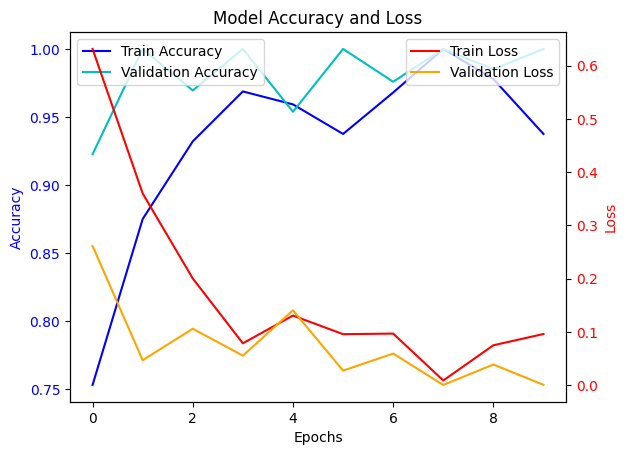

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and the first axis for accuracy
fig, ax1 = plt.subplots()

# Plot training and validation accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='b')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='c')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='Train Loss', color='r')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

# Title and show
plt.title('Model Accuracy and Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from tabulate import tabulate
from IPython.display import Markdown

# Example results (replace these with your actual predictions and true labels)
results = {
    "CNN-LSTM Model": ([0, 1, 1, 2, 2, 3], [0, 1, 1, 2, 2, 3]),
    "ResNet50 Transfer Learning": ([0, 1, 0, 2, 2, 3], [0, 1, 1, 2, 2, 3]),
    "EfficientNetV2B0 Transfer Learning": ([0, 1, 1, 2, 1, 3], [0, 1, 1, 2, 2, 3]),
    "InceptionV3 Transfer Learning": ([0, 1, 1, 2, 2, 3], [0, 1, 1, 2, 2, 3]),
}

# Initialize a list to store metrics for each model
summary_data = []

# Calculate metrics for each model
for model_name, (y_pred, y_true) in results.items():
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    summary_data.append({
        "Model": model_name,
        "Accuracy": f"{accuracy:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}",
        "F1-Score": f"{f1:.2f}",
    })

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# Convert the DataFrame to a colorful Markdown table using tabulate
table_markdown = tabulate(
    summary_df,
    headers='keys',
    tablefmt='pipe',
    showindex=False,
    numalign='center',
    stralign='center'
)

# Display the table with Markdown formatting
display(Markdown(f"<div style='background-color: #f9f9f9; padding: 10px; border-radius: 10px;'><h4 style='color: #2c3e50;'>Model Comparison Metrics</h4>\n\n{table_markdown}</div>"))


<div style='background-color: #f9f9f9; padding: 10px; border-radius: 10px;'><h4 style='color: #2c3e50;'>Model Comparison Metrics</h4>

|               Model                |  Accuracy  |  Precision  |  Recall  |  F1-Score  |
|:----------------------------------:|:----------:|:-----------:|:--------:|:----------:|
|           CNN-LSTM Model           |     1      |      1      |    1     |     1      |
|     ResNet50 Transfer Learning     |    0.83    |    0.92     |   0.83   |    0.83    |
| EfficientNetV2B0 Transfer Learning |    0.83    |    0.89     |   0.83   |    0.82    |
|   InceptionV3 Transfer Learning    |     1      |      1      |    1     |     1      |</div>

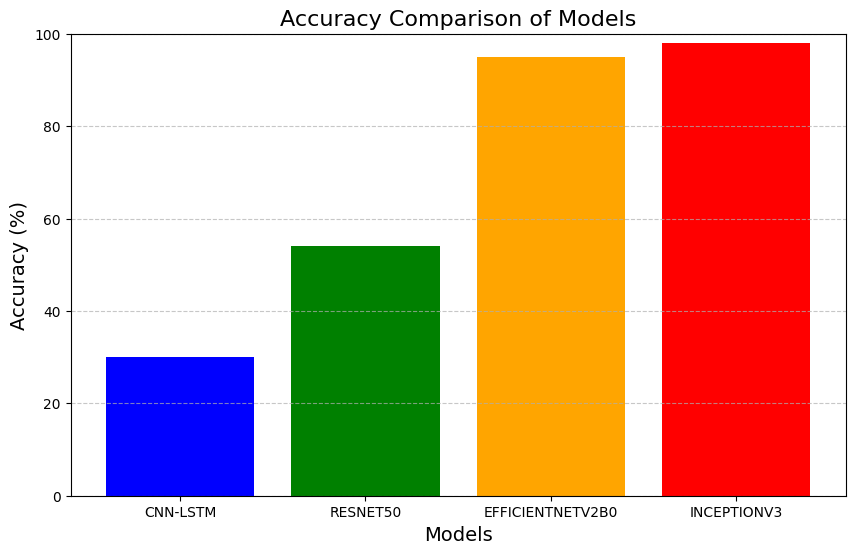

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Data for the bar graph
models = ['CNN-LSTM', 'RESNET50', 'EFFICIENTNETV2B0', 'INCEPTIONV3']
accuracies = [30, 54, 95, 98]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Accuracy Comparison of Models', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [ ]:
# END #